### Librerias de spark

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [2]:
!wget https://dlcdn.apache.org/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz

--2021-11-29 00:52:43--  https://dlcdn.apache.org/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 220400553 (210M) [application/x-gzip]
Saving to: ‘spark-3.0.3-bin-hadoop2.7.tgz.3’

spark-3.0.3-bin-had 100%[===================>] 210.19M   155MB/s    in 1.4s    

2021-11-29 00:52:45 (155 MB/s) - ‘spark-3.0.3-bin-hadoop2.7.tgz.3’ saved [220400553/220400553]



In [3]:
!tar xf /content/spark-3.0.3-bin-hadoop2.7.tgz

In [4]:
!pip install -q findspark

In [5]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"

In [6]:
import findspark
findspark.init("/content/spark-3.0.3-bin-hadoop2.7") #Spark home
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [7]:
#Obtener el Spark Context del Spark Session
SpContext = spark.sparkContext

In [ ]:
####################################################################
###############################################
################## FUNCTIONS ##################
###############################################

# Sigmoid Activation function
def sigmoid(X):
    return 1 / (1 + np.exp(-X))

# Sigmoid prime function (used for backward prop)
def sigmoid_prime(x):
    sig = sigmoid(x)
    return sig * (1 - sig)

# Cost function
def sse(y_pred, y_true):
    return 0.5 * np.sum(np.power(y_pred - y_true, 2))
  
# Compute the layer propagation before activation
def preforward(x, w, b):
    return np.dot(x, w) + b

# Compute the layer propagation after activation
# This is also equivalent to a predict function once model is trained
def predict(x, W1, B1, W2, B2):
    return sigmoid(preforward(sigmoid(preforward(x , W1, B1)), W2, B2))

# Compute the derivative of the error regarding B2
def derivativeB2(y_pred, y_true, y_h, f_prime):
    return (y_pred - y_true) * f_prime(y_h)

# Compute the derivative of the error regarding W2
def derivativeW2(h, dB2):
    return np.dot(h.T, dB2)

# Compute the derivative of the error regarding B1
def derivativeB1(h_h, dB2, W2, f_prime):
    return np.dot(dB2, W2.T) * f_prime(h_h)

# Compute the derivative of the error regarding W1
def derivativeW1(x, dB1):
    return np.dot(x.T, dB1)

######################################################
################## MODEL DEFINITION ##################
######################################################

# Hyperparameters
num_iteration = 50
learningRate = 0.1

input_layer = 784 # number of neurones in the input layer (equal to image size)
hidden_layer = 64 # number of neurones in the hidden layer (Custom)
output_layer = 2 # number of neurones in the output layer (equal to the number of possible labels)

# Paramater Initialization
W1 = np.random.rand(input_layer, hidden_layer) - 0.5 # Shape (784, 64)
W2 = np.random.rand(hidden_layer, output_layer) - 0.5 # Shape (64, 2)
B1 = np.random.rand(1, hidden_layer) - 0.5 # Shape (1, 64)
B2 = np.random.rand(1, output_layer) - 0.5 # Shape (1, 2)

####################################################
################## MODEL TRAINING ##################
####################################################

# History over epochs
cost_history, acc_history = [], []

# Epoch Loop (mini batch implementation)
for i in range(num_iteration):
  
    ################## Notations ######################
    # x -> Input Image flatten of shape (1, 784)
    # y* -> One hot label of shape (1, 2)
    # h^ -> Forward prop from Input layer to hidden layer before activation (1, 64) using W1, B1 param
    # h -> Forward prop from Input layer to hidden layer after tanh activation (1, 64)
    # y^ -> Forward prop from hidden layer to output layer before activation (1, 2) using W2, B2 param
    # y -> Forward prop from hidden layer to output layer after sigmoid activation (1, 2)
    # E -> Error between y and y* using SSE
    # Acc -> 1 is right prediction 0 otherwise
    # DE/D? -> Partial derivative of the Error regarding parmaters (B2, W2, B1, W1)
    
    ################# Forward Prop ######################
    # map batch ([x], [y*]) to ([x], [h^],[y*])
    # map batch ([x], [h^],[y*]) to ([x], [h^], [h], [y*])
    # map batch ([x], [h^], [h], [y*]) to ([x], [h^], [h], [y^], [y*])
    # map batch ([x], [h^], [h], [y^], [y*]) to ([x], [h^], [h], [y^], [y], [y*])
    ################# Backward Prop #####################
    # map batch ([x], [h^], [h], [y^], [y], [y*]) to ([x], [h^], [h], [E], [DE/DB2], [Acc])
    # map batch ([x], [h^], [h], [E], [DE/DB2], [Acc]) to ([x], [h^], [E], [DE/DB2], [DE/DW2], [Acc])
    # map batch ([x], [h^], [E], [DE/DB2], [DE/DW2], [Acc]) to ([x], [E], [DE/DB2], [DE/DW2], [DE/DB1], [Acc])
    # map batch ([x], [E], [DE/DB2], [DE/DW2], [DE/DB1], [Acc]) to ([E], [DE/DB2], [DE/DW2], [DE/DB1], [DE/DW1],[Acc])
    ############### Reduce over the mini batch #########
    
    # Compute gradients, cost and accuracy over mini batch 
    gradientCostAcc = train_rdd\
        .sample(False,0.7)\
        .map(lambda x: (x[0], preforward(x[0], W1, B1), x[1]))\
        .map(lambda x: (x[0], x[1], activation(x[1], sigmoid), x[2]))\
        .map(lambda x: (x[0], x[1], x[2], preforward(x[2], W2, B2), x[3]))\
        .map(lambda x: (x[0], x[1], x[2], x[3], activation(x[3], sigmoid), x[4]))\
        .map(lambda x: (x[0], x[1], x[2], sse(x[4], x[5]), derivativeB2(x[4], x[5], x[3], sigmoid_prime), int(np.argmax(x[4]) == np.argmax(x[5]))))\
        .map(lambda x: (x[0], x[1], x[3], x[4],  derivativeW2(x[2], x[4]) ,x[5]))\
        .map(lambda x: (x[0], x[2], x[3], x[4],  derivativeB1(x[1],  x[3], W2, sigmoid_prime) ,x[5]))\
        .map(lambda x: (x[1], x[2], x[3], x[4], derivativeW1(x[0], x[4]) ,x[5], 1)) \
        .reduce(lambda x, y: (x[0] + y[0], x[1] + y[1], x[2] + y[2], x[3] + y[3], x[4] + y[4], x[5] + y[5], x[6] + y[6]))

    # Cost and Accuarcy of the mini batch
    n = gradientCostAcc[-1] # number of images in the mini batch
    cost = gradientCostAcc[0]/n # Cost over the mini batch
    acc = gradientCostAcc[5]/n # Accuarcy over the mini batch
    
     # Add to history
    cost_history.append(cost)
    acc_history.append(acc)

    # Extract gradiends and average them over the batch size
    DB2 = gradientCostAcc[1]/n
    DW2 = gradientCostAcc[2]/n
    DB1 = gradientCostAcc[3]/n
    DW1 = gradientCostAcc[4]/n
            
    # Update parameter with new learning rate and gradients using Gradient Descent
    B2 -= learningRate * DB2
    W2 -= learningRate * DW2
    B1 -= learningRate * DB1
    W1 -= learningRate * DW1

    # Display performances
    print(f"   Epoch {i+1}/{num_iteration} | Cost: {cost_history[i]} | Acc: {acc_history[i]*100} | Batchsize:{n}")

In [8]:
from google.colab import files
uploaded = files.upload()

Saving Normal-1.png to Normal-1.png


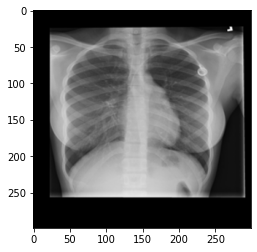

In [14]:
import cv2
import matplotlib.pyplot as plt
img=cv2.imread('Normal-1.png' , 1)
plt.imshow(img)

In [15]:
collData = SpContext.parallelize([img])

In [22]:
collData.take(5)

[array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8)]

In [23]:
print(collData.take(5))

[array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)]


In [17]:
cylData = collData.map(lambda x: (collData,1))

In [19]:
print(type(cylData))

<class 'pyspark.rdd.PipelinedRDD'>


In [27]:
print(cylData.take(3))

Traceback (most recent call last):
  File "/content/spark-3.0.3-bin-hadoop2.7/python/pyspark/serializers.py", line 468, in dumps
    return cloudpickle.dumps(obj, pickle_protocol)
  File "/content/spark-3.0.3-bin-hadoop2.7/python/pyspark/cloudpickle.py", line 1097, in dumps
    cp.dump(obj)
  File "/content/spark-3.0.3-bin-hadoop2.7/python/pyspark/cloudpickle.py", line 357, in dump
    return Pickler.dump(self, obj)
  File "/usr/lib/python3.7/pickle.py", line 437, in dump
    self.save(obj)
  File "/usr/lib/python3.7/pickle.py", line 504, in save
    f(self, obj) # Call unbound method with explicit self
  File "/usr/lib/python3.7/pickle.py", line 789, in save_tuple
    save(element)
  File "/usr/lib/python3.7/pickle.py", line 504, in save
    f(self, obj) # Call unbound method with explicit self
  File "/content/spark-3.0.3-bin-hadoop2.7/python/pyspark/cloudpickle.py", line 501, in save_function
    self.save_function_tuple(obj)
  File "/content/spark-3.0.3-bin-hadoop2.7/python/pyspark

PicklingError: ignored

In [ ]:
import numpy as np
import torch
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np 
import math 
from skimage.io import imread, imshow
import os

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


**Carga de datos local**

In [ ]:
path_Covid = r'C:\Users\ASUS\Desktop\UTEC\Redes Neuronales (CNN)\Clasificador\COVID' 
path_Normal = r'C:\Users\ASUS\Desktop\UTEC\Redes Neuronales (CNN)\Clasificador\Normal'

In [ ]:
#### Funcion para leer imagenes dentro de una carpeta
width = 299
height = 299
def imageReading (path):
    folderFilesids = os.listdir(path)
    images = np.zeros((len(folderFilesids), height, width))
    for count, n in enumerate(folderFilesids):
        path1 = path + '\\' + n
        originalImage = imread(path1)[:,:]    
        images[count] = originalImage
    imshow(images[0])
    plt.show()
    return images

C:\Users\ASUS\anaconda3\envs\pytorch\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


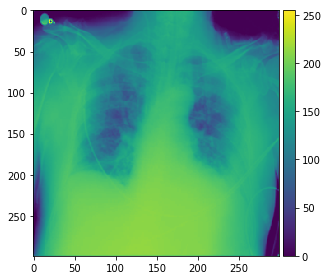

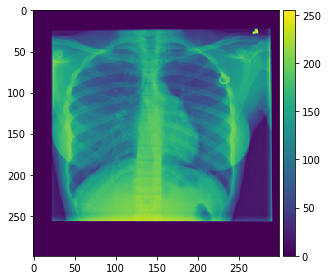

In [ ]:
covid = imageReading(path_Covid)
normal = imageReading(path_Normal)

In [ ]:
covid.shape

(99, 299, 299)

In [ ]:
normal.shape

(99, 299, 299)

**Agregando dimensiones para que sea leido por pytorch**

In [ ]:
covid = torch.from_numpy(np.array(covid).reshape(-1,1,299,299)) ## torch se convierte nuestra data en tensor - Aumenta la dimension.
normal = torch.from_numpy(np.array(normal).reshape(-1,1,299,299)) # (-1: Cantidad de imagenes, 1: gris o color, 299 x 299: tamaño de la imagen

In [ ]:
covid.shape

torch.Size([99, 1, 299, 299])

In [ ]:
covid[0]

tensor([[[185.,  40.,   0.,  ...,   0.,  24., 131.],
         [ 75.,  14.,   0.,  ...,   0.,   8.,  42.],
         [ 11.,   2.,   0.,  ...,   1.,   3.,  12.],
         ...,
         [ 78.,  62.,  68.,  ...,   3.,  13.,  27.],
         [104.,  74.,  75.,  ...,   1.,  23.,  83.],
         [156.,  90.,  78.,  ...,   1.,  45., 167.]]], dtype=torch.float64)

### Agregamos las etiquetas y transformamos a tuple

In [ ]:
img_covidlist = []
for i in range(covid.shape[0]):
      img_covidlist.append((covid[i]/255.0,0.0))

img_normallist = []
for i in range(normal.shape[0]):
      img_normallist.append((normal[i]/255.0,1.0))

In [ ]:
img_normallist[0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]], dtype=torch.float64),
 1.0)

### Verificar el Slicing y tamaño de las listas

In [ ]:
len(img_covidlist)

99

In [ ]:
len(img_covidlist[int(len(img_covidlist)*0.7):])

30

In [ ]:
len(img_covidlist[0:int(len(img_covidlist)*0.7)])

69

In [ ]:
len(img_normallist)

99

In [ ]:
import random
random.shuffle(img_covidlist)
covid_train = img_covidlist[0:int(len(img_covidlist)*0.7)]
covid_test = img_covidlist[int(len(img_covidlist)*0.7):]

random.shuffle(img_normallist)
normal_train = img_normallist[0:int(len(img_normallist)*0.7)]
normal_test = img_normallist[int(len(img_normallist)*0.7):]

### COVID 

In [ ]:
print("El tamaño del training es {} y del test es {}".format(len(covid_train), len(covid_test)))

El tamaño del training es 69 y del test es 30


### NORMAL

In [ ]:
print("El tamaño del training es {} y del test es {}".format(len(normal_train), len(normal_test)))

El tamaño del training es 69 y del test es 30


### Unir Train de Covid y Normal y Test de Covid y Normal 

In [ ]:
train_beta = covid_train + normal_train
test_beta = covid_test + normal_test

In [ ]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(dataset=train_beta, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_beta, batch_size=batch_size, shuffle=True)

## CNN

**Para la construccion de la red convolucional tener en cuenta:**
**Conv2d:** Se usa por que estamos trabajando con imagenes en 2 dimensiones
**in_channel:** Es la cantidad de canales, en caso sea una imagen en gris es 1, si es RGB es 3. Luego puede ir variando a medida que incrementamos el numero de capas.
**out_channels:** Es la cantidad de dimensiones de salida, es decir entra una imagen en escala de grises y salen 16 imagenes adicionales.
**Kernel_size:** El tamaño del kernel que se aplicara, siempre es una matriz cuadrada. Para nuestro caso 4x4
**Stride:** Espacio para el recorrido entre kernel y kernel.
**Pading:** Es una especio de relleno que se le aplica, este relleno puede darse en la parte superior o inferior.

**Nota:** Es importante conocer estos conceptos para saber la salida que se le entregara, se debe aplicar la siguiente formula:  


$\text{Tamaño de salida } = \frac{\text{Tamaño de la imagen } - \text{ Tamaño de kernel } + 2*\text{ Pading }}{Stride}$

In [ ]:
#hyperparameter 
num_classes = 2
learning_rate =  0.001
num_epochs = 20

class CNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CNN, self).__init__()
        #input 299x299
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=4, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2,padding=0)) #150 x 150
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=0),  #146
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))  #73x73
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=0),  #36
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fc = nn.Linear(18*18*64, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        #print('aviso1')
        out = self.layer2(out)
        #print('aviso2')
        out = self.layer3(out)
        #print('aviso3')
        out = out.reshape(out.size(0), -1)
        #print('aviso4')
        out = self.fc(out)
        return out 

In [ ]:
model         = CNN(num_classes).to(device)
loss_fn       = nn.CrossEntropyLoss()
optimizer     = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
def train(model, optimizer, loos_fn, num_epochs):
    loss_vals = []
    running_loss =0.0
    # train the model
    total_step = len(train_loader)  # el train loader es el motor que se encarga de sacar las imagenes del train_set

    list_loss= []
    list_time = []
    j=0

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.float().to(device)
            labels = labels.long().to(device)
            # forward 
            output = model(images).float()
            loss   = loss_fn(output, labels)
            # change the params
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            list_loss.append(loss.item())
            list_time.append(j)
            j+=1

            if (i+1) % 100 == 0:
                  print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                        .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    print('Finished Training Trainset')
    return list_loss

In [ ]:
error_train = train(model,optimizer,loss_fn, num_epochs=20)

Finished Training Trainset


## Accuracy en el Test 

In [ ]:
with torch.no_grad():
    y_true = []
    y_pred = []  
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.float().to(device), labels.float().to(device)           
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        y_true.append(labels.cpu().data.numpy()) 
        y_pred.append(predicted.cpu().data.numpy())  
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the {} test images: {} %'.format(len(test_beta), 100 * correct / total))

Test Accuracy of the model on the 60 test images: 68.33333333333333 %


In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

confusion_matrix(list(itertools.chain(*y_true)), list(itertools.chain(*y_pred)))

array([[19, 11],
       [ 8, 22]], dtype=int64)

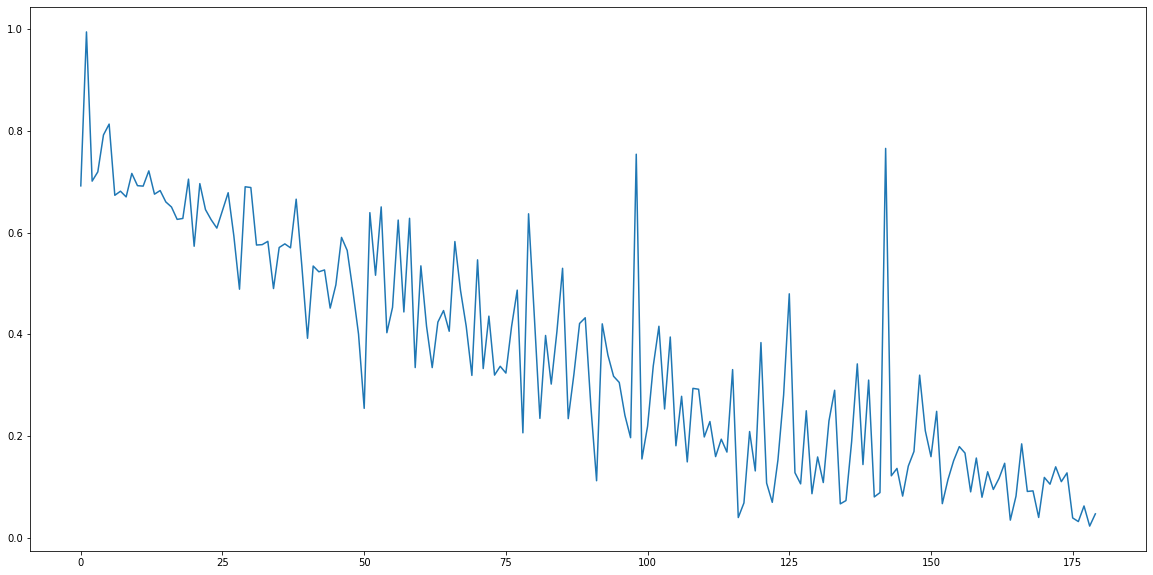

In [ ]:
import matplotlib.pyplot as plt
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)
plt.plot(error_train)
plt.show()